In [7]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

db = client.adsE_database
collection = db.adsE_collection

In [8]:
elements = ['Cu', 'Pt', 'Ag', 'Pd', 'Au', 'Ni', 'Al', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis

[{'element': 'Cu', 'face': '100'},
 {'element': 'Cu', 'face': '111'},
 {'element': 'Cu', 'face': '110'},
 {'element': 'Cu', 'face': '211'},
 {'element': 'Pt', 'face': '100'},
 {'element': 'Pt', 'face': '111'},
 {'element': 'Pt', 'face': '110'},
 {'element': 'Pt', 'face': '211'},
 {'element': 'Ag', 'face': '100'},
 {'element': 'Ag', 'face': '111'},
 {'element': 'Ag', 'face': '110'},
 {'element': 'Ag', 'face': '211'},
 {'element': 'Pd', 'face': '100'},
 {'element': 'Pd', 'face': '111'},
 {'element': 'Pd', 'face': '110'},
 {'element': 'Pd', 'face': '211'},
 {'element': 'Au', 'face': '100'},
 {'element': 'Au', 'face': '111'},
 {'element': 'Au', 'face': '110'},
 {'element': 'Au', 'face': '211'},
 {'element': 'Ni', 'face': '100'},
 {'element': 'Ni', 'face': '111'},
 {'element': 'Ni', 'face': '110'},
 {'element': 'Ni', 'face': '211'},
 {'element': 'Al', 'face': '100'},
 {'element': 'Al', 'face': '111'},
 {'element': 'Al', 'face': '110'},
 {'element': 'Al', 'face': '211'},
 {'element': 'Rh', '

In [12]:
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        inst = dataset_utilizer(**dictlis[i])
        dfall.append(inst.dfall)
        df.append(inst.df)
        dfpred.append(inst.dfpred)
    except:

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


In [14]:
dfall[0]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_CO,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,COlengthlis,converged,not_moved,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e63e6b915ba89a05c1dad38,Pt_100_u2_RPBE_no002_CO_n1_d9.traj,yes,No,Pt,100,2,RPBE,CO,1,0.25,4,-97.106993,-80.945998,-14.485436,-1.675559,-0.418890,-1.675559,0.004287,None,None,31.857979,0.031389,[1],[1],[1.1875732543409188],yes,yes,yes,yes,None,None,None
1,5e63e94415ba89a05c1dae0a,Pt_100_u2_RPBE_no001_CO_n1_d9.traj,yes,No,Pt,100,2,RPBE,CO,1,0.25,4,-97.016057,-80.945998,-14.485436,-1.584623,-0.396156,-1.584623,0.004287,None,None,31.857979,0.031389,[0],[0],[1.1654340827663832],yes,yes,yes,yes,None,None,None
2,5e63e94515ba89a05c1dae0d,Pt_100_u2_RPBE_no003_CO_n1_d9.traj,yes,No,Pt,100,2,RPBE,CO,1,0.25,4,-96.544401,-80.945998,-14.485436,-1.112966,-0.278242,-1.112966,0.004287,None,None,31.857979,0.031389,[2],[2],[1.2083458530680544],yes,yes,yes,yes,None,None,None


In [15]:
### Exclude coverage > 1.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['aveadsE/suratom'] >= -2.0]

In [16]:
dfall[3][dfall[3]['numberofads']==1]

IndexError: list index out of range

In [91]:
file = 'Cu_211_u2_RPBE_no075_CO_n1_d8' + '.traj' 
init_query(file,'local')
query(file, 'local')

Atoms(symbols='Cu24CO', pbc=True, cell=[6.369163110459296, 5.200399903061017, 28.256743780796448], constraint=FixAtoms(indices=[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]), calculator=SinglePointCalculator(...))

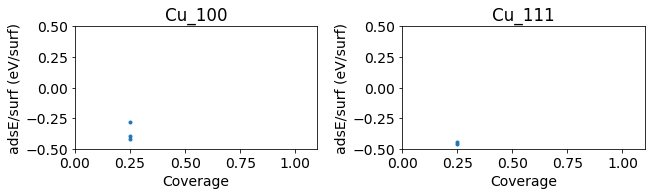

In [17]:
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(df[i]['coverage'], df[i]['aveadsE/suratom'], '.')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-0.5,0.5])    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [18]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(df[i]['coverage']))))
covset

[[0.25], [0.25]]

In [19]:
eneset = copy.deepcopy(covset)
for i in range(len(covset)):
    for j in range(len(covset[i])):
        eneset[i][j] = df[i][df[i]['coverage'] == covset[i][j]]['aveadsE/suratom'].min()

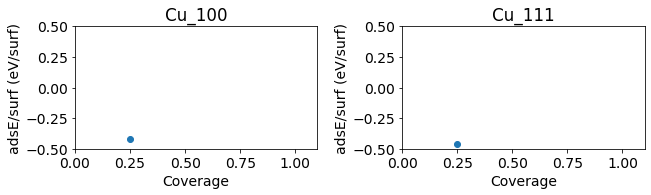

In [20]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(covset[i], eneset[i], 'o')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.set_xlim([0,1.1])
    ax.set_ylim([-0.5,0.5])    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [21]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [22]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(eneset)):
    tmp = []
    for p in prange:
        tmp.append(eneset[i]-kb*T*np.log(p/Pref)*np.array(covset[i]))
    pres.append(tmp)

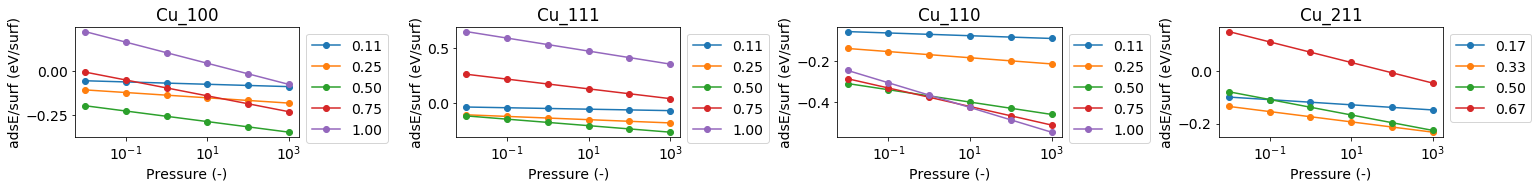

In [107]:
# for i in range(len(pres)):
#     plt.plot(prange, pres[i], 'o-')
#     plt.xscale('log')
#     plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     plt.xlabel('Pressure (-)')
#     plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
# #     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
#     plt.show()
    
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Pressure (-)')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 1))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.8, wspace=0.7)
# plt.savefig('')
plt.show()

In [91]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression()

In [65]:
def linearfit(X, y):
    index = 1
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [66]:
densityset = []
for i in range(len(covset)):
    densityset.append(covset[i]/df[i][df[i]['unitlength'] ==1]['area'][0])

IndexError: index out of bounds

In [58]:
def func(X, slope, a2, a3, a4, a5, a6, a7, a8):
    return slope*X + a2*X**2 + a3*X**3 + a4*X**4 + a5*X**5 + a6*X**6 + a7*X**7 + a8*X**8

In [59]:
def MSE(A):
    a2, a3, a4, a5, a6, a7, a8 = A
    mse = 0
    for i in range(0,6):
        X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
        X = np.array(X)
        y = np.array(y)    
        X_ = X.reshape(-1, 1)
        fitres, slope = linearfit(X_, y)

        mse += sum((y - func(X, slope, a2, a3, a4, a5, a6, a7, a8))**2)
    return mse

In [60]:
from scipy.optimize import minimize
sol = minimize(MSE, [1,1,1,1,1,1,1])
sol.x

array([  2.94617638, 207.33786796,  54.18047667,  11.69643123,
         2.9723561 ,   1.35008345,   1.0611724 ])

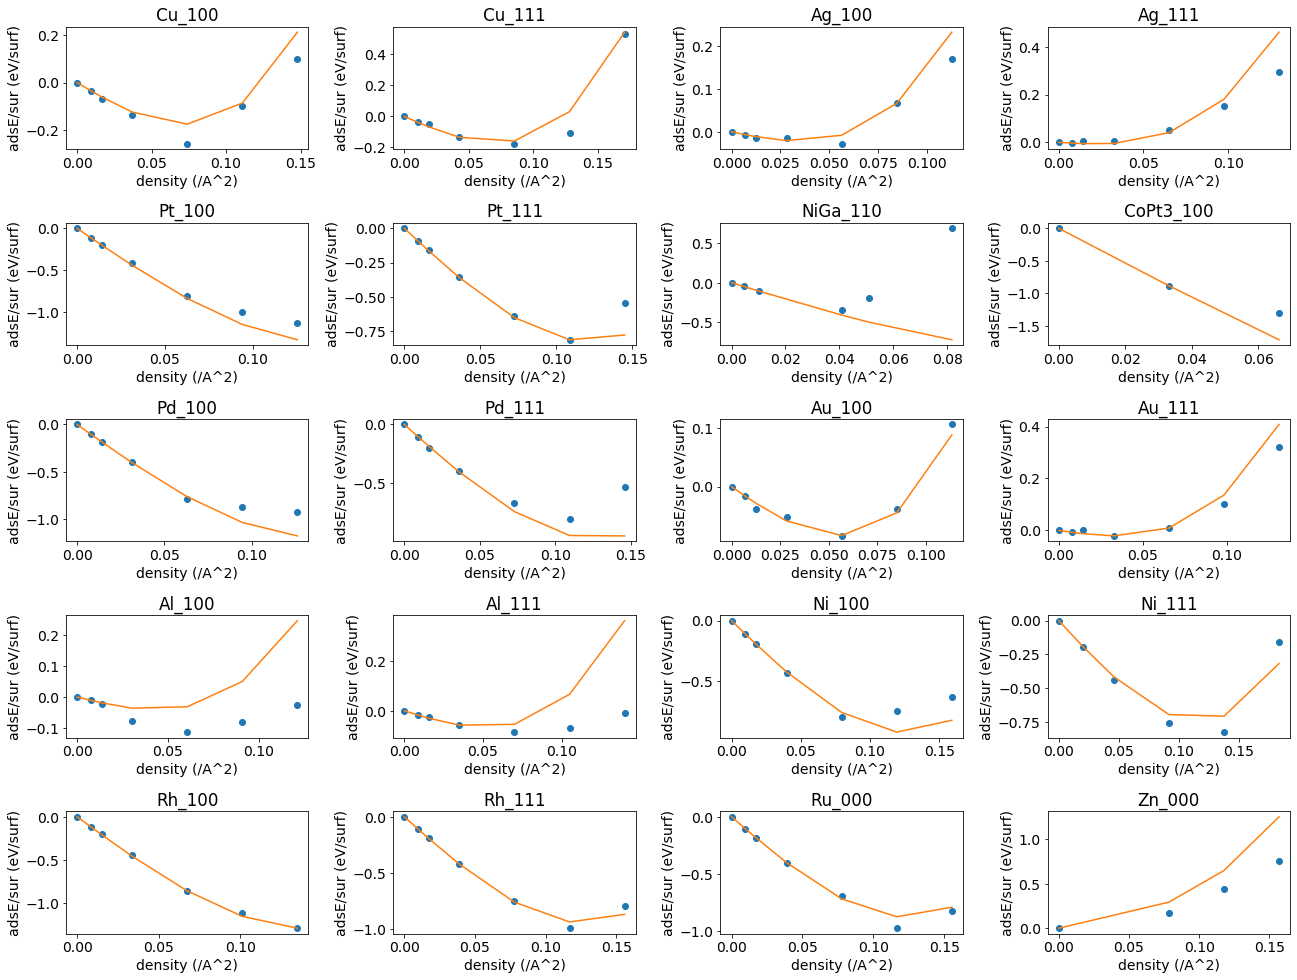

In [61]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)

    ax.plot(X, y, 'o')
    ax.plot(X, func(X, slope, *sol.x), '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('density (/A^2)')
    ax.set_ylabel('adsE/sur (eV/surf)')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()